# Scripts for Toymodel 1

##### Please cite [.]: Van A. Ngo, Yen Ting Li, Danny Perez. "Improving Estimatioon of Koopman Operators with Kolmogorov-Smirnov Indicator functions." Copyright: LANL.

In [1]:
import numpy as np
import pandas as pd
import pyemma
import pyemma.coordinates as coor
from matplotlib import rcParams
from matplotlib import pyplot as plt

In [2]:
#Major scripts here
# build 2D KS matrix
def KS_measure(x,block=100):
    from scipy.stats import ks_2samp, cumfreq, kstest
    d1=np.reshape(x, x.size)
    #block=100000
    print('using block =',block)
    l=len(d1)
    nb=int(l/block)
    KS=np.zeros((nb,nb))
    for i in range(nb):
        ki1=i*block
        ki2=(i+1)*block
        dai=d1[ki1:ki2]
        for j in range(i,nb):
            kj1=j*block
            kj2=(j+1)*block
            daj=d1[kj1:kj2]
            D,p=ks_2samp(dai,daj)
            KS[i,j]=D
            KS[j,i]=D
    return KS

#Clustering using Distance Threshold in AgglomerativeClustering
class clustering:
    def __init__(self,KS,k=6,block=100):
        from scipy.cluster.hierarchy import dendrogram, linkage
        from scipy.cluster.hierarchy import fcluster
        import sklearn.cluster
        def kdtd(n):
            return 1.6*np.sqrt(2*n/n**2)*k
        print("Danny's Threshold: ",kdtd(block))
        cls=sklearn.cluster.AgglomerativeClustering(n_clusters=None,  affinity='precomputed', memory=None, connectivity=None, compute_full_tree='auto', linkage='average', distance_threshold=kdtd(block))
        #cls.fit(KS)
        self.clustertime=cls.fit(KS).labels_
        
        tg2=[]
        av=np.average(self.clustertime)
        nstate=np.unique(self.clustertime)
        for st  in nstate:
            tg=[]
            print('indicator function ', st)
            for cl in self.clustertime:
                if cl == st:
                    tg=np.concatenate((tg,np.full(block,1)))
                else:
                    tg=np.concatenate((tg,np.full(block,0)))
            tg2.append(tg)    
        self.cluster_KS_surrogate=tg2
        self.Single_cluster_KS_surrogate=[]
        for cl in self.clustertime:
            self.Single_cluster_KS_surrogate=np.concatenate((self.Single_cluster_KS_surrogate,np.full(block,cl-av)))

# Clustering using number of clusters in AgglomerativeClustering
class clustering2:
    def __init__(self,KS,k=2,block=100):
        from scipy.cluster.hierarchy import dendrogram, linkage
        from scipy.cluster.hierarchy import fcluster
        import sklearn.cluster
        #def kdtd(n):
        #    return 1.6*np.sqrt(2*n/n**2)*k
        print("Using number of ",k,'clusters')
        cls=sklearn.cluster.AgglomerativeClustering(n_clusters=k,  affinity='precomputed', memory=None, connectivity=None, compute_full_tree='auto', linkage='average')
        #cls.fit(KS)
        self.clustertime=cls.fit(KS).labels_
        
        tg2=[]
        av=np.average(self.clustertime)
        nstate=np.unique(self.clustertime)
        self.Single_cluster_KS_surrogate=[]
        for st  in nstate:
            tg=[]
            print('indicator function ', st)
            for cl in self.clustertime:
                
                if cl == st:
                    tg=np.concatenate((tg,np.full(block,1)))
                else:
                    tg=np.concatenate((tg,np.full(block,0)))
            tg2.append(tg)    
        self.cluster_KS_surrogate=tg2
        for cl in self.clustertime:
            self.Single_cluster_KS_surrogate=np.concatenate((self.Single_cluster_KS_surrogate,np.full(block,cl-av)))

In [3]:
# computing timescale using k-means clustering and MSM
def get_timescale(x,kmeans=2,lag=20,max_iter=100,dovamp=False,doplot=True,doclustering=True):
    import pyemma
    import pyemma.coordinates as coor
    import numpy as np
    output=x
    if dovamp:
        print('perform VAMP transformation')
        output=coor.vamp(x,lag=lag).get_output();# this step is not necessary for toy model 1
    
    if doclustering:
        #print('do k-means clustering with',kmeans,'clusters','lagtime=',lag)
        kmeans_clustering=coor.cluster_kmeans(data=output,k=kmeans,max_iter=max_iter)
        dtrajs=kmeans_clustering.dtrajs
    else:
        dtrajs=x
    msm=pyemma.msm.estimate_markov_model(dtrajs,lag=lag)
    timescale=msm.timescales()[0]
    #plot x vs dtrajs
    if doplot:
        time=np.arange(len(dtrajs[0]))
        fig,ax=plt.subplots(1,1)
        ax.plot(time,x)
        ax.plot(time,dtrajs[0],label='k-means')
        ax.set_ylim(min(x)-0.5,max(x)+0.5)
    #ax.set_yticks(np.arange(0,1.5,1))
        ax.set_ylabel('Discretized Trajectory',weight='bold')
        ax.set_xlabel('Time (step)',weight='bold')
        plt.legend(frameon=False)
        plt.tight_layout()
        plt.savefig('kmeans_clustering_traj-model1.png',dpi=100,bbox_inches='tight')
        plt.show()

    return timescale

In [4]:
# compute indicator functions with KS measure and AgglomerativeClustering
def get_indicator(x,b=500,k=2,clustering_type='nclusters'):
    KS=KS_measure(x,block=b)
    if clustering_type == 'nclusters':
        KS_clustering=clustering2(KS,k=k,block=b); # if clustering with number of cluster
    if clustering_type == 'Distance':
        KS_clustering=clustering(KS,k=k,block=b); # k here is the constant for computing distance threshold
    #it takes some minutes to compute KS proximity matrix
    #put x and indicator functions together
    l=min(len(x),len(KS_clustering.cluster_KS_surrogate[0])); # just in case len(x)%b !=0
    data1=[x[:l]]
    for tg in KS_clustering.cluster_KS_surrogate:
        data1.append(tg)
    data1=np.asarray(data1).T
    print(np.shape(data1))
    #print(data1)
    return data1

# Parameters for toy model 1

In [5]:

length=500000
b=500
sigma=np.asarray([0.1, 0.1])
mu = np.asarray([0.0, 1])
trans=np.asarray([0.0001, 0.0001])
lag=20
k=6; # using for computing distance threshold

In [6]:
# load panda pickle which contains 100 in dependent trajectories with a length = 500000/traj.
df=pd.read_pickle('../data/100_samples_toy_model1.pkl')
print(df)

                                           timeseries  \
0   [1.0942525962594516, 0.8718137773338024, 0.980...   
1   [0.9150254847734349, 1.0193953107798652, 0.979...   
2   [0.041517676823563325, -0.09070349552888445, 0...   
3   [-0.019743546288656603, -0.08686399511773898, ...   
4   [-0.03757686226754112, 0.011734899846416944, 0...   
..                                                ...   
95  [0.9989888910517748, 0.9522199074133569, 0.947...   
96  [0.002098013980046321, 0.0981677915358255, 0.0...   
97  [0.8219427154985788, 1.0419905357536097, 0.998...   
98  [0.9775635665221687, 1.0399276622509996, 1.116...   
99  [0.018693855347159505, 0.07416103662782239, -0...   

                                  indicator functions  \
0   [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...   
1   [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...   
2   [[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0...   
3   [[0.0, 1.0], [0.0, 1.0], [0.0, 1.0], [0.0, 1.0...   
4   [[0.0, 1.0], [0.0, 1.0], [

In [7]:
#Pick a trajectory and plot it
fr=9
x=df['timeseries'][fr]
ind=df['indicator functions'][fr][:,1]; # there are two complementary indicator functions for each time-series x.


kmeans iterations:   0%|                                                              | 0/200 [00:00<?, ?it/s]

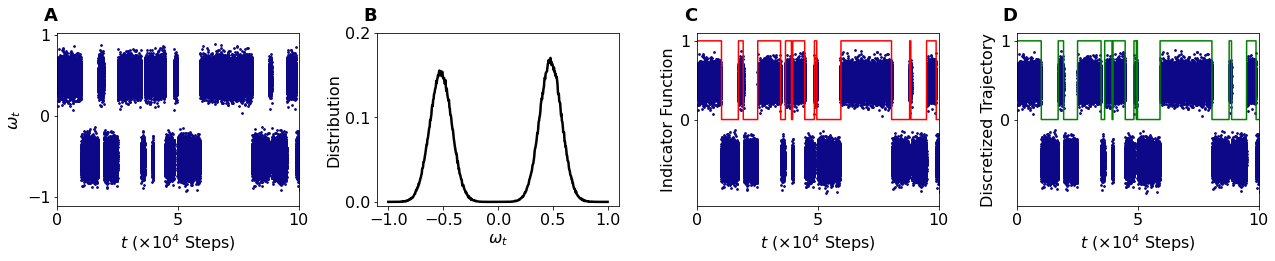

In [13]:
# Plot Figure 2(A-D)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':16, 'font.family':'sans'})
fig = plt.figure(figsize=(18,4))
ax = [plt.subplot(1,4,i+1) for i in range(4)]
colors = cm.plasma(np.linspace(0,1,12))
ms = 3
letter=['A', 'B', 'C', 'D']
xlabel=[r'$t$ $(\times 10^4$ $\mathrm{Steps})$',r'$\omega_t$',
        r'$t$ $(\times 10^4$ $\mathrm{Steps})$',
        r'$t$ $(\times 10^4$ $\mathrm{Steps})$']
ylabel=[r'$\omega_t$','Distribution','Indicator Function','Discretized Trajectory']
#get zero mean
x0=x-np.average(x)
hisx,ix=np.histogram(x0,bins=500,range=[-1,1])
hisx=hisx/np.sum(hisx)*20
#compute discretize trajectory from kmeans, also indicator function
discretize_clustering=coor.cluster_kmeans(data=x0,k=2,max_iter=200)
dtrajs=discretize_clustering.dtrajs
for i in range(0,4):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
    ax[i].text(0, 1.15, letter[i], transform=ax[i].transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')
t=np.arange(0,len(x),1)
ax[0].scatter(t/10000,x0, ms,  color = colors[0]); # raw data
ax[1].plot(ix[:500], hisx, ms,  color = 'black',lw=2.5); #histogram
ax[2].plot(t/10000,ind,ms,  color = 'red'); #indicator function
ax[2].scatter(t/10000,x0,ms,  color = colors[0]); #indicator function
ax[3].plot(t/10000,np.full(len(dtrajs[0]),1)-dtrajs[0],ms,  color = 'green'); #discretized
ax[3].scatter(t/10000,x0,ms,  color = colors[0]); #indicator function
ax[0].set_yticks([-1,0,1])
ax[1].set_ylim(-0.005,.1)
ax[1].set_yticks([0,0.1,0.2])
ax[0].set_xticks([0,5,10])
for i in [0,2,3]:
    ax[i].set_xlim(0,100000/10000)
for i in [2,3]:
    ax[i].set_ylim(-1.1,1.1)
    ax[i].set_yticks([0,1])
    ax[i].set_xticks([0,5,10])

plt.tight_layout()
fig.savefig('HMM_toymodel1.png',dpi=300,bbox_inches='tight')

In [9]:
#compute timescale using x-$\muy$
vamp_x=coor.vamp(x,lag=lag)
t_x=-lag/np.log(vamp_x.singular_values[0])
print('computed timescale is',t_x,'----pre-computed is',df['Timescale using x-$\muy$'][fr])

computed timescale is 453.0920413705096 ----pre-computed is 453.0920413705096


do k-means clustering with 2 clusters lagtime= 20


kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

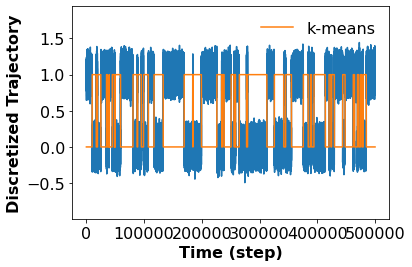

computed timescale using k-means clustering and MSM is 4094.5998687832034


In [10]:
# compute timescale using k-means clustering and MSM
t_MSM= get_timescale(x)
print('computed timescale using k-means clustering and MSM is',t_MSM)
#t_MSM should be close to df['Timescale using Indicator Function'][fr] for Toy model 1

In [13]:
data1=get_indicator(x,b=b,k=6);# recomputed, just for a test

using block = 500
Danny's Threshold:  0.6071573107523288
indicator function  0
indicator function  1
(500000, 3)


0.496 0.504


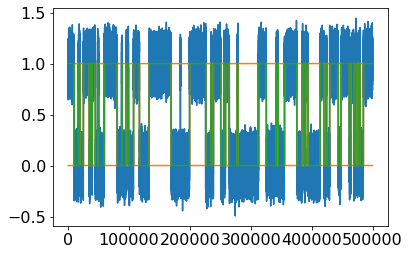

In [14]:
plt.plot(data1[:,0])
plt.plot(data1[:,1])
plt.plot(data1[:,2]);# the second indicator function should be complementary to the first
print(np.average(data1[:,1]),np.average(data1[:,2]))

In [15]:
#compute timescale with {indicator functions} and with both {x and indicator functions} as basis sets
vamp_IF=coor.vamp(data1[:,1:],lag=lag,dim=1);# dim = 1 is for comparing VAMP-score with the same dimension
vamp_xIF=coor.vamp(data1,lag=lag,dim=1)
print('VAMPScore for {x} as basis set is',vamp_x.score(),'with timescale is',-lag/np.log(vamp_x.singular_values[0]))
print('VAMPScore for {Indicator Function} as basis set is',vamp_IF.score(),
      'with timescale is',-lag/np.log(vamp_IF.singular_values[0]))
print('VAMPScore for {x and Indicator Function} as basis set is',vamp_xIF.score(),
      'with timescale is',-lag/np.log(vamp_xIF.singular_values[0]))
print('the pre-computed timescale is',df['Timescale using Indicator Function'][fr])

VAMPScore for {x} as basis set is 1.915502409116896 with timescale is 453.0920413705096
VAMPScore for {Indicator Function} as basis set is 1.9907405747331386 with timescale is 4299.891540392203
VAMPScore for {x and Indicator Function} as basis set is 1.9915475853598383 with timescale is 4712.347210428957
the pre-computed timescale is 4712.347210428957


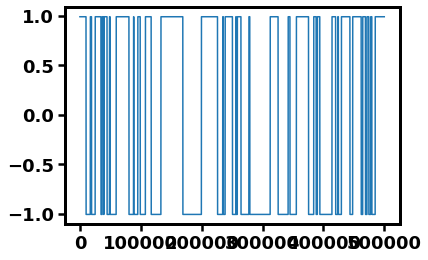

In [247]:
plt.plot(np.stack(vamp_IF.get_output()[0]))

In [8]:
# Compute Vamp scores as function of lag time
def timescale_vs_lag(x0,ind,lag_range):
    org=[]
    IF=[]
    t_org=[]
    t_IF=[]
    for lag in lag_range:
        vamp_x=coor.vamp(x0,dim=1,lag=lag)
        vamp_IF=coor.vamp(ind,dim=1,lag=lag)
        org.append(vamp_x.score())
        IF.append(vamp_IF.score())
        t_org.append(-lag/np.log(vamp_x.singular_values[0]))
        t_IF.append(-lag/np.log(vamp_IF.singular_values[0]))
    return org,IF,t_org,t_IF
lag_range=range(20,10000,100)
vs_org=[]
vs_IF=[]
ts_org=[]
ts_IF=[]
for x,aind in zip(df['timeseries'],df['indicator functions']):
    x0=x-np.average(x)
    ind=aind[:,1]
    org,IF,t_org,t_IF=timescale_vs_lag(x0,ind,lag_range)
    vs_org.append(org)
    vs_IF.append(IF)
    ts_org.append(t_org)
    ts_IF.append(t_IF)

In [11]:
#computing timescale using kmeans+MSM for all trajectories

all_dtrajs=[]
for x in df['timeseries']:
    kmeans_clustering=coor.cluster_kmeans(data=x,k=2,max_iter=100)
    dtrajs=kmeans_clustering.dtrajs
    all_dtrajs.append(dtrajs)

ts_MSM=[]
for dtrajs in all_dtrajs:
    lt_x_MSM=[]
    for lag in lag_range:
        msm=pyemma.msm.estimate_markov_model(dtrajs,lag=lag)
        lt_x_MSM.append(msm.timescales()[0])
    ts_MSM.append(lt_x_MSM)

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

kmeans iterations:   0%|                                                        | 0/100 [00:00<?, ?it/s]

In [79]:
#compute averages and errors of the mean
n=len(lag_range)
nsample=len(df['timeseries'])
#nsample=10
print(n,nsample)
ave_vs_org=[]
ave_vs_IF=[]
ave_ts_org=[]
ave_ts_IF=[]
ave_ts_MSM=[]

e_vs_org=[]
e_vs_IF=[]
e_ts_org=[]
e_ts_IF=[]
e_ts_MSM=[]
for i in range(n):
    #vampscore
    ave_vs_org.append(np.average(np.vstack(vs_org)[:nsample,i]))
    ave_vs_IF.append(np.average(np.vstack(vs_IF)[:nsample,i]))
    #timescale
    ave_ts_org.append(np.average(np.vstack(ts_org)[:nsample,i]))
    ave_ts_IF.append(np.average(np.vstack(ts_IF)[:nsample,i]))
    ave_ts_MSM.append(np.average(np.vstack(ts_MSM)[:nsample,i]))
    #error for vampscore
    e_vs_org.append(np.std(np.vstack(vs_org)[:nsample,i])/np.sqrt(nsample))
    e_vs_IF.append(np.std(np.vstack(vs_IF)[:nsample,i])/np.sqrt(nsample))
    #error for timescale
    e_ts_org.append(np.std(np.vstack(ts_org)[:nsample,i])/np.sqrt(nsample))
    e_ts_IF.append(np.std(np.vstack(ts_IF)[:nsample,i])/np.sqrt(nsample))
    e_ts_MSM.append(np.std(np.vstack(ts_MSM)[:nsample,i])/np.sqrt(nsample))
    print("%f %.2f +/- %.2f, %.2f +/- %.2f, %.2f +/- %.2f, %.2f +/- %.2f," %
          (lag_range[i],ave_vs_org[-1],e_vs_org[-1],
           ave_vs_IF[-1], e_vs_IF[-1],
           ave_ts_org[-1],e_ts_org[-1],
           ave_ts_IF[-1], e_ts_IF[-1]),
           ave_ts_MSM[-1], e_ts_MSM[-1])
            
                   

100 100
20.000000 1.92 +/- 0.00, 1.99 +/- 0.00, 454.33 +/- 1.14, 5359.42 +/- 79.09, 4983.4814871502585 73.01140908346224
120.000000 1.88 +/- 0.00, 1.95 +/- 0.00, 1864.83 +/- 10.65, 5308.13 +/- 79.08, 4980.995403443367 72.01870424705287
220.000000 1.84 +/- 0.00, 1.92 +/- 0.00, 2602.41 +/- 20.11, 5256.52 +/- 79.07, 4982.2555229861155 71.6825840033857
320.000000 1.81 +/- 0.00, 1.88 +/- 0.00, 3058.10 +/- 27.57, 5204.57 +/- 79.07, 4985.7042664278115 72.32663056895214
420.000000 1.78 +/- 0.00, 1.85 +/- 0.00, 3368.32 +/- 33.59, 5152.27 +/- 79.07, 4990.075686819994 73.25894046000111
520.000000 1.75 +/- 0.00, 1.81 +/- 0.00, 3593.46 +/- 38.36, 5116.45 +/- 79.07, 4994.76646719836 74.02779756796919
620.000000 1.72 +/- 0.00, 1.78 +/- 0.00, 3766.92 +/- 42.49, 5132.98 +/- 79.22, 5002.454650410451 74.9820238792012
720.000000 1.69 +/- 0.00, 1.75 +/- 0.00, 3903.77 +/- 46.10, 5131.47 +/- 79.52, 5008.183190932535 76.04069525512863
820.000000 1.66 +/- 0.00, 1.72 +/- 0.00, 4013.47 +/- 49.12, 5117.92 +/- 79.

7620.000000 1.05 +/- 0.00, 1.05 +/- 0.00, 4785.70 +/- 114.67, 4919.05 +/- 122.17, 4914.876361690701 121.0809799150564
7720.000000 1.04 +/- 0.00, 1.05 +/- 0.00, 4782.35 +/- 116.04, 4912.69 +/- 123.34, 4909.259095867182 122.46288313025313
7820.000000 1.04 +/- 0.00, 1.05 +/- 0.00, 4777.80 +/- 117.41, 4904.78 +/- 124.60, 4903.215125614406 123.78146494037007
7920.000000 1.04 +/- 0.00, 1.04 +/- 0.00, 4772.77 +/- 118.65, 4895.28 +/- 125.97, 4896.6229341180115 125.0176923322189
8020.000000 1.04 +/- 0.00, 1.04 +/- 0.00, 4767.20 +/- 120.03, 4885.63 +/- 127.38, 4889.030741277845 126.38213009059868
8120.000000 1.04 +/- 0.00, 1.04 +/- 0.00, 4761.15 +/- 121.42, 4880.37 +/- 128.66, 4881.258387057636 127.72858423854264
8220.000000 1.04 +/- 0.00, 1.04 +/- 0.00, 4755.09 +/- 122.80, 4873.57 +/- 130.05, 4873.544524246376 129.07394939730975
8320.000000 1.03 +/- 0.00, 1.04 +/- 0.00, 4749.46 +/- 124.02, 4865.14 +/- 131.58, 4866.16558316079 130.27706707482227
8420.000000 1.03 +/- 0.00, 1.04 +/- 0.00, 4743.07 

In [14]:
lag_range,ave_vs_org,e_vs_org,ave_vs_IF, e_vs_IF,ave_ts_org,e_ts_org,ave_ts_IF, e_ts_IF,ave_ts_MSM, e_ts_MSM=np.loadtxt('figure3a_data.txt',unpack=True)

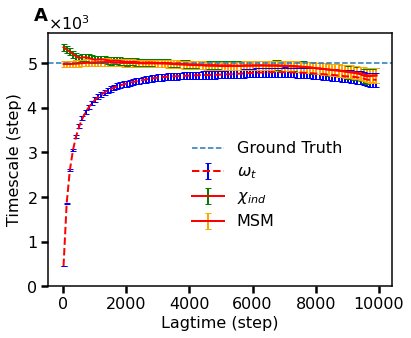

In [31]:
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width']=2.5
rcParams['ytick.major.width']=2.5
rcParams['xtick.major.size']=7
rcParams['ytick.major.size']=7
plt.rc('font',size=16,weight='normal')

llag=np.arange(20,10000,100)
fig,ax2=plt.subplots(1,1,figsize=(6,5))
#ax=ax2.twinx()
ax2.set_xlabel('Lagtime (step)',weight='normal')
#ax.set_ylabel('VAMP Score',weight='normal')
#ax.errorbar(llag,ave_vs_org,yerr=e_vs_org,ls='--',color='black',linewidth=2,label=r'$\omega_t$')
#ax.errorbar(llag,ave_vs_IF,yerr=e_vs_IF,color='black',linewidth=2,label=r'$\chi_{ind}$')

ax2.errorbar(llag,ave_ts_org,yerr=e_ts_org,ecolor='blue',capsize=3,ls='--',color='red',linewidth=2,label=r'$\omega_t$')
ax2.errorbar(llag,ave_ts_IF,yerr=e_ts_IF,ecolor='green',capsize=3,color='red',linewidth=2,label=r'$\chi_{ind}$')
ax2.errorbar(llag,ave_ts_MSM,yerr=e_ts_MSM,ecolor='orange',capsize=3,color='red',linewidth=2,label=r'MSM')
ax2.set_ylabel("Timescale (step)",color="black")
ax2.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
ax2.set_yticks(np.arange(0,6000,1000))
ax2.axhline(y=5000,ls='--',label='Ground Truth')
#ax2.set_ylim(0,5000)
#ax.set_ylim(1.,2.5)
#ax.set_yticks([1,1.5,2,2.5])
ax2.text(0, 1.1, 'A', transform=ax2.transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')
#ax.set_ylim(1,2)
#ax.legend(frameon=False,loc=[0.7,0.285])
ax2.legend(frameon=False,loc=[0.4,0.2])
plt.tight_layout()
plt.savefig('ToyModel1_VAMP_score.png',dpi=300,bbox_inches='tight')

# Examine quality of indicator functions as functions of $d_{\mathrm{KS}}$ (distance threshold) via b (block size) and number of clusters

In [21]:
#1. test for b (delta_t in Figure 5) (not using $d_{KS}, but fix nclusters=2)
def timescale_vs_b(x,k=2,lag=1000,brange=range(200,1500,50)):
    timescale=[]
    for tblock in brange:
        #xind=get_indicator(x,b=tblock,k=k,clustering_type='Distance'); # can test this as well
        xind=get_indicator(x,b=tblock,k=k,clustering_type='nclusters')
        vamp_xind=coor.vamp(xind,dim=1,lag=lag)
        timescale.append(-lag/np.log(vamp_xind.singular_values[0]))
    return timescale
print('Computing timecale for all samples for block')
ts_vs_b=[]
countsp=0
nsample=10; # get similar order of errors (~100) if using 100 samples; saving computational time.
brange=range(200,1500,50)
for x in df['timeseries']:
    ts_vs_b.append(timescale_vs_b(x))
    countsp+=1
    print('sample',countsp)
    if countsp == nsample:
        break

Computing timecale for all samples for block
using block = 200
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 250
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 300
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 350
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 

indicator function  1
(500000, 3)
using block = 300
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 350
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
in

indicator function  1
(499800, 3)
using block = 400
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 450
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 800
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 850
Using number of  2 clusters
in

indicator function  1
(499950, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 550
Using number of  2 clusters
indicator function  0
indicator function  1
(499950, 3)
using block = 600
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 650
Using number of  2 clusters
indicator function  0
indicator function  1
(499850, 3)
using block = 700
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 750
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 800
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 850
Using number of  2 clusters
indicator function  0
indicator function  1
(499800, 3)
using block = 900
Using number of  2 clusters
indicator function  0
indicator function  1
(499500, 3)
using block = 950
Using number of  2 clusters
in

In [22]:
#2. test for number of clusters
def timescale_vs_nclusters(x,b=500,lag=1000,nrange=[1,2,4,6,8]):
    timescale=[]
    for k in nrange:
        vamp_x=coor.vamp(x,lag=lag)
        xind=get_indicator(x,b=b,k=k,clustering_type='nclusters')
        vamp_xIF=coor.vamp(xind,dim=1,lag=lag)
        t_xIF=-lag/np.log(vamp_xIF.singular_values[0])
        timescale.append(t_xIF)
    return timescale
##### do for all samples
print('Computing timecale for all samples for nclusters')
ts_vs_nclusters=[]
countsp=0
nsample=10; # get similar order of errors (~100) if using 100 samples; saving computational time.
for x in df['timeseries']:
    ts_vs_nclusters.append(timescale_vs_nclusters(x))
    countsp+=1
    print('sample',countsp)
    if countsp == nsample:
        break
#########


Computing timecale for all samples for nclusters
using block = 500
Using number of  1 clusters
indicator function  0
(500000, 2)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  4 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
(500000, 5)
using block = 500
Using number of  6 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
indicator function  4
indicator function  5
(500000, 7)
using block = 500
Using number of  8 clusters
indicator function  0
indicator function  1
indicator function  2
indicator function  3
indicator function  4
indicator function  5
indicator function  6
indicator function  7
(500000, 9)
sample 1
using block = 500
Using number of  1 clusters
indicator function  0
(500000, 2)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using bl

In [24]:
print(np.shape(np.vstack(ts_vs_b)))
print(np.shape(np.vstack(ts_vs_nclusters)))
ave_ts_vs_b=[]
ave_ts_vs_n=[]

e_ts_vs_b=[]
e_ts_vs_n=[]
brange=range(200,1500,50)
for i in range(len(brange)):
    
    #timescale
    ave_ts_vs_b.append(np.average(np.vstack(ts_vs_b)[:,i]))
    #error for timescale
    e_ts_vs_b.append(np.std(np.vstack(ts_vs_b)[:,i])/np.sqrt(nsample))
    print("%f %.2f +/- %.2f" %
          (i,ave_ts_vs_b[-1],e_ts_vs_b[-1]))

####       
nrange = [1,2,4,6,8]    
for i in range(len(nrange)):
    
    #timescale
    ave_ts_vs_n.append(np.average(np.vstack(ts_vs_nclusters)[:,i]))
    #error for timescale
    e_ts_vs_n.append(np.std(np.vstack(ts_vs_nclusters)[:,i])/np.sqrt(nsample))
    
    print("%f %.2f +/- %.2f " %
          (i,ave_ts_vs_n[-1], e_ts_vs_n[-1]))

(10, 26)
(10, 5)
0.000000 4869.57 +/- 226.85
1.000000 4870.99 +/- 240.82
2.000000 4886.27 +/- 226.06
3.000000 4924.90 +/- 240.72
4.000000 4933.14 +/- 228.26
5.000000 5001.95 +/- 231.65
6.000000 5043.55 +/- 220.89
7.000000 5032.79 +/- 239.95
8.000000 5113.38 +/- 238.18
9.000000 5179.49 +/- 226.22
10.000000 5196.19 +/- 253.58
11.000000 5262.78 +/- 236.50
12.000000 5235.70 +/- 270.73
13.000000 5322.84 +/- 255.15
14.000000 5333.31 +/- 224.19
15.000000 5431.40 +/- 262.74
16.000000 5359.94 +/- 255.66
17.000000 5498.64 +/- 230.37
18.000000 5654.98 +/- 323.02
19.000000 5565.21 +/- 235.93
20.000000 5535.40 +/- 254.88
21.000000 5797.72 +/- 298.49
22.000000 5886.95 +/- 277.51
23.000000 5855.41 +/- 266.14
24.000000 6026.36 +/- 241.22
25.000000 6015.11 +/- 323.04
0.000000 4015.07 +/- 158.29 
1.000000 5043.55 +/- 220.89 
2.000000 5654.42 +/- 296.00 
3.000000 6074.30 +/- 295.43 
4.000000 6340.17 +/- 354.35 


/Users/vanngo/Research/Danny/Scripts_Data_2Release


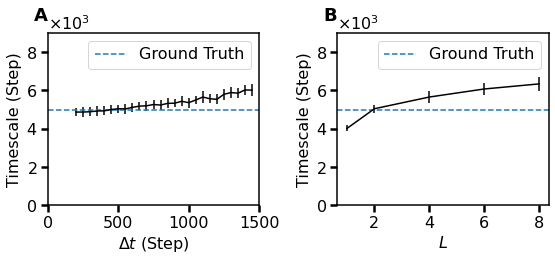

In [28]:
# Plot Figure 2(A-D)
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
plt.rcParams.update({'font.size':16, 'font.family':'sans'})
fig = plt.figure(figsize=(8,4))
ax = [plt.subplot(1,2,i+1) for i in range(2)]
colors = cm.plasma(np.linspace(0,1,12))
ms = 3
letter=['A', 'B']
xlabel=[r'$\Delta t$ (Step)',r'$L$']
ylabel=[r'Timescale (Step)',r'Timescale (Step)']
#print(e_ts_vs_b)
for i in range(2):
    ax[i].set_xlabel(xlabel[i])
    ax[i].set_ylabel(ylabel[i])
    ax[i].text(0, 1.15, letter[i], transform=ax[i].transAxes,   fontsize=18, fontweight='bold', va='top', ha='right')

for i in [0,1]:
    ax[i].set_ylim(0,9000)
    ax[i].axhline(y=5000,ls='--',label='Ground Truth')
    ax[i].set_yticks([0,2000,4000,6000,8000])
    ax[i].ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
    ax[i].legend()
ax[0].set_xticks(np.arange(0,1550,500))
ax[0].set_xlim(0,1500)
ax[0].errorbar(brange,ave_ts_vs_b,yerr=e_ts_vs_b,   color = 'black');
ax[1].errorbar(nrange,ave_ts_vs_n,yerr=e_ts_vs_n,  color = 'black'); 


plt.tight_layout()
fig.savefig('dKS_toymodel1.png',dpi=300,bbox_inches='tight')
!pwd

# Test timescale as function of $\mu$

In [89]:
#load data from pickle
muydata=pd.read_pickle('../data/Muy2_samples_toy_model1.pkl')
print(muydata)

    sigma1=sigma2  muy2                                         timeseries  \
0             0.2   0.2  [0.10096423577272323, 0.11152675133912797, 0.4...   
1             0.2   0.4  [0.6537214225927797, 0.11326562445763921, 0.41...   
2             0.2   0.6  [-0.20905604170226377, 0.1460465335757444, 0.2...   
3             0.2   0.8  [0.585799007490557, 0.8927389590671094, 0.8152...   
4             0.2   1.0  [0.05344259017719188, 0.370207714862268, -0.15...   
5             0.2   1.2  [0.27794460268625276, 0.32104241491392627, -0....   
6             0.2   1.4  [1.3899757738267005, 1.5111830206283376, 1.149...   
7             0.2   1.6  [1.4614907758542832, 1.6081787294186731, 1.556...   
8             0.2   1.8  [-0.02885759970801261, 0.22951609641977677, 0....   
9             0.2   2.0  [-0.007092579482499889, -0.13551947959329305, ...   
10            0.2   2.2  [2.079712050637413, 2.309534950581962, 2.39288...   
11            0.2   2.4  [-0.5248525005516383, -0.13229274650719

In [90]:
def compare_VAMP_vs_theoretical(sigma0=muydata['sigma1=sigma2'][0],
                                lag=20,timeseries=muydata['timeseries'],
                                indicators=muydata['Ground True Hidden functions'],
                                allmuy=muydata['muy2'],p1=trans[0],p2=trans[1],,maxi=500000,b=500):
    pi1=p1/(p1+p2)
    pi2=p2/(p1+p2)
    # note sigma[0]==sigma[1] for simply
    t_xVAMP=[]
    t_iVAMP=[]
    t_iKSVAMP=[]
    t_iMSM=[]
    tmuy_theo=[]
    for muy2,x,indi in zip(allmuy,timeseries,indicators):
        plt.plot(x)
        gamma=1/(4*(sigma0/muy2)**2+1)
        vamp_x=coor.vamp(x,dim=1,lag=lag)
        t_x=-lag/np.log(vamp_x.singular_values[0])
        t_xVAMP.append(t_x)
        
        #using ground true indicator functions
        vamp_i=coor.vamp(indi,dim=1,lag=lag)
        t_i=-lag/np.log(vamp_i.singular_values[0])
        t_iVAMP.append(t_i)
        
        #Using KS indicator functions
        ind_KS=get_indicator(x,b=b,k=2,clustering_type='nclusters')
        if np.shape(ind_KS)[1]>2:
            vamp_iKS=coor.vamp(ind_KS[:,1:],dim=1,lag=lag)
            t_iKS=-lag/np.log(vamp_iKS.singular_values[0])
            t_iKSVAMP.append(t_iKS)
        else:
            t_iKSVAMP.append(0)
        
        t_iMSM.append(get_timescale(np.int0(indi),dovamp=False, doplot=False,doclustering=False))
        #std=np.std(x)
        #gamma=muy2**2*pi1*pi2/std/std
        t_theoretical=1.0/(-np.log(1-p1-p2)-np.log(gamma)/lag)
        tmuy_theo.append(t_theoretical)
        #print(muy2,t_theoretical,t_x,)
    return  tmuy_theo, t_xVAMP, t_iVAMP,t_iKSVAMP,t_iMSM

In [ ]:
lag =20
tmuy_theo, t_xVAMP,t_iVAMP,t_iKSVAMP, t_iMSM=compare_VAMP_vs_theoretical(lag=lag)

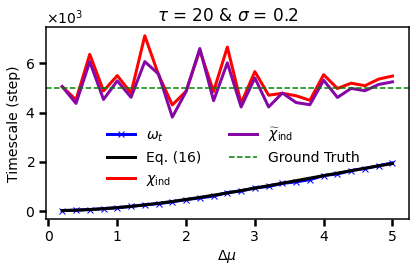

In [94]:

sigma0=muydata['sigma1=sigma2'][0]
plt.rc('font',size=14,weight='normal')


#muy= muy2/2
plt.plot(muydata['muy2'],t_xVAMP,marker='x',label=r'$\omega_t$',lw=3,color='blue')
plt.plot(muydata['muy2'],tmuy_theo,label='Eq. (16)',lw=3,color='black')
plt.plot(muydata['muy2'],t_iKSVAMP,label='$\chi_{\mathrm{ind}}$',lw=3,color='red')
plt.plot(muydata['muy2'],t_iVAMP,label='$\widetilde{\chi}_{\mathrm{ind}}$',lw=3,color=colors[3])
#plt.plot(muydata['muy2'],t_iMSM,label='MSM $\chi_{\mathrm{ind}}$($x_t$)',lw=3,color='orange')
plt.ylabel('Timescale (step)',weight='normal' )
plt.xlabel(r'$\Delta \mu$',weight='normal')
plt.axhline(y=5000,ls='--',color='green',label='Ground Truth')
plt.title(r'$k$ = '+str(lag)+' & $\sigma$ = '+str(sigma0),weight='normal')
plt.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
plt.legend(frameon=False,bbox_to_anchor=(0.4, 0.05, 0.5, 0.5),ncol=2)
plt.tight_layout()
plt.savefig(str(sigma0)+str(lag)+'vs.muy2.png',dpi=300,bbox_inches='tight')

using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator function  1
(500000, 3)
using block = 500
Using number of  2 clusters
indicator function  0
indicator func

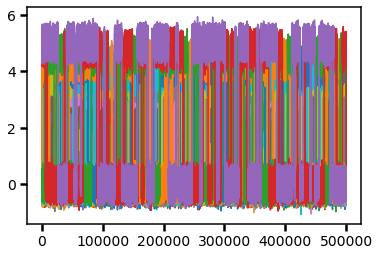

In [95]:
lag =200
tmuy_theo200, t_xVAMP200,t_iVAMP200,t_iKSVAMP200, t_iMSM200=compare_VAMP_vs_theoretical(lag=lag)

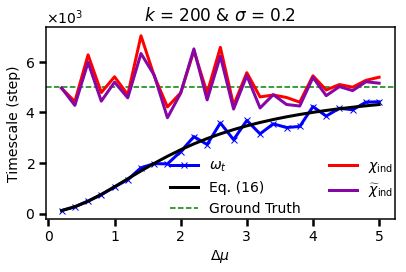

In [96]:

sigma0=muydata['sigma1=sigma2'][0]
plt.rc('font',size=14,weight='normal')


plt.plot(muydata['muy2'],t_xVAMP200,marker='x',label=r'$\omega_t$',lw=3,color='blue')
plt.plot(muydata['muy2'],tmuy_theo200,label='Eq. (16)',lw=3,color='black')
plt.axhline(y=5000,ls='--',color='green',label='Ground Truth')
plt.plot(muydata['muy2'],t_iKSVAMP200,label='$\chi_{\mathrm{ind}}$',lw=3,color='red')
plt.plot(muydata['muy2'],t_iVAMP200,label='$\widetilde{\chi}_{\mathrm{ind}}$',lw=3,color=colors[3])
#plt.plot(muydata['muy2'],t_iMSM200,label='MSM $\chi_{\mathrm{ind}}$($x_t$)',lw=3,color='orange')
plt.ylabel('Timescale (step)',weight='normal' )
plt.xlabel(r'$\Delta \mu$',weight='normal')

plt.title(r'$k$ = '+str(lag)+' & $\sigma$ = '+str(sigma0),weight='normal')
plt.ticklabel_format(axis='y',style='scientific',scilimits=[0,3],useMathText=True,useLocale=True)
plt.legend(frameon=False,bbox_to_anchor=(0.32, 0.0, 0.35, 0.38),ncol=2)
plt.tight_layout()
plt.savefig(str(sigma0)+str(lag)+'vs.muy2.png',dpi=300,bbox_inches='tight')

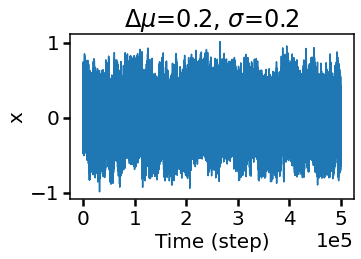

In [106]:
i=0
sigma0=muydata['sigma1=sigma2'][0]
plt.rc('font',size=20,weight='normal')
muy2=muydata['muy2'][i]
x=muydata['timeseries'][i]
x=x-np.average(x)
plt.plot(x)
plt.title(r'$\Delta \mu$='+str(muy2)[:3]+', $\sigma $='+ str(sigma0),weight='normal')
plt.ylabel(r'x',weight='normal')
plt.xlabel('Time (step)',weight='normal')
plt.xticks([0,100000,200000,300000,400000,500000])
plt.tight_layout()
plt.ticklabel_format(scilimits=(-3,4))
plt.savefig('Timesereies_at'+str(sigma0)+str(muy2)[:3]+'.png',dpi=300,bbox_inches='tight')

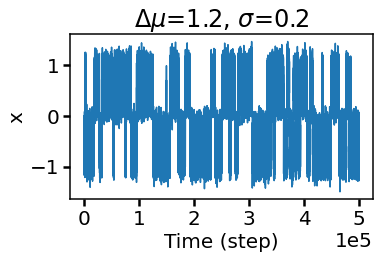

In [108]:
i=5
plt.rc('font',size=20,weight='normal')
muy2=muydata['muy2'][i]
x=muydata['timeseries'][i]
x=x-np.average(x)
plt.plot(x)
plt.title(r'$\Delta \mu$='+str(muy2)[:3]+', $\sigma $='+ str(sigma0),weight='normal')
plt.ylabel(r'x',weight='normal')
plt.xlabel('Time (step)',weight='normal')
plt.xticks([0,100000,200000,300000,400000,500000])
plt.tight_layout()
plt.ticklabel_format(scilimits=(-3,4))
plt.savefig('Timesereies_at'+str(sigma0)+str(muy2)[:3]+'.png',dpi=300,bbox_inches='tight')

In [26]:
# testing polynomial functions
vampscore=[]
timescale=[]
fri=9
x=df['timeseries'][fri]
upto_data=[]
lag=2000
for i in range(1,30):
    upto_data.append(x**i)
    tg=coor.vamp(upto_data,dim=1,lag=lag)
    score=tg.score()
    vampscore.append(score)
    timescale.append(-lag/np.log(tg.singular_values[0]))
    print(np.shape(upto_data),i,score,timescale[-1])

(1, 500000) 1 1.314615466257613 3458.9983756241572
(2, 500000) 2 1.3021232725141187 3341.910464174527


calculate covariances:   0%|                                          | 0/3 [00:00<?, ?it/s]

(3, 500000) 3 1.2797318811168452 3139.905469753318


calculate covariances:   0%|                                          | 0/4 [00:00<?, ?it/s]

(4, 500000) 4 1.2518699603291101 2900.9842823613303


calculate covariances:   0%|                                          | 0/5 [00:00<?, ?it/s]

(5, 500000) 5 1.220996164171608 2649.69109509913


calculate covariances:   0%|                                          | 0/6 [00:00<?, ?it/s]

(6, 500000) 6 1.1890551956817146 2401.3693579470323


calculate covariances:   0%|                                          | 0/7 [00:00<?, ?it/s]

(7, 500000) 7 1.1577204321208567 2165.7547041490748


calculate covariances:   0%|                                          | 0/8 [00:00<?, ?it/s]

(8, 500000) 8 1.1283576800232713 1948.4303703427922


calculate covariances:   0%|                                          | 0/9 [00:00<?, ?it/s]

(9, 500000) 9 1.1019676538526602 1752.004134438823


calculate covariances:   0%|                                         | 0/10 [00:00<?, ?it/s]

(10, 500000) 10 1.079151640016035 1577.0446811228146


calculate covariances:   0%|                                         | 0/11 [00:00<?, ?it/s]

(11, 500000) 11 1.060124651144606 1422.811403875739


calculate covariances:   0%|                                         | 0/12 [00:00<?, ?it/s]

(12, 500000) 12 1.0447757079091518 1287.792889812607


calculate covariances:   0%|                                         | 0/13 [00:00<?, ?it/s]

(13, 500000) 13 1.0327599898836217 1170.0876469667073


calculate covariances:   0%|                                         | 0/14 [00:00<?, ?it/s]

(14, 500000) 14 1.0236001023069614 1067.661946280762


calculate covariances:   0%|                                         | 0/15 [00:00<?, ?it/s]

(15, 500000) 15 1.0167757382979759 978.5162871082603


calculate covariances:   0%|                                         | 0/16 [00:00<?, ?it/s]

(16, 500000) 16 1.0117892560030368 900.785934952914


calculate covariances:   0%|                                         | 0/17 [00:00<?, ?it/s]

(17, 500000) 17 1.0082042518600054 832.7950112402875


calculate covariances:   0%|                                         | 0/18 [00:00<?, ?it/s]

(18, 500000) 18 1.0056612053243683 773.078551466344


calculate covariances:   0%|                                         | 0/19 [00:00<?, ?it/s]

(19, 500000) 19 1.0038773581299474 720.3830815051501


calculate covariances:   0%|                                         | 0/20 [00:00<?, ?it/s]

(20, 500000) 20 1.0026379033612716 673.653479596014


calculate covariances:   0%|                                         | 0/21 [00:00<?, ?it/s]

(21, 500000) 21 1.0017838264778645 632.0119239025694


calculate covariances:   0%|                                         | 0/22 [00:00<?, ?it/s]

(22, 500000) 22 1.0011996754851644 594.7332633602133


calculate covariances:   0%|                                         | 0/23 [00:00<?, ?it/s]

(23, 500000) 23 1.0008028599300482 561.2199569567482


calculate covariances:   0%|                                         | 0/24 [00:00<?, ?it/s]

(24, 500000) 24 1.0005349918539892 530.9786879962612


calculate covariances:   0%|                                         | 0/25 [00:00<?, ?it/s]

(25, 500000) 25 1.0003552055497746 503.5998625899172


calculate covariances:   0%|                                         | 0/26 [00:00<?, ?it/s]

(26, 500000) 26 1.0002351569184202 478.74048002237066


calculate covariances:   0%|                                         | 0/27 [00:00<?, ?it/s]

(27, 500000) 27 1.0001553534596117 456.11034568375686


calculate covariances:   0%|                                         | 0/28 [00:00<?, ?it/s]

(28, 500000) 28 1.0001024985766798 435.46128241561877


calculate covariances:   0%|                                         | 0/29 [00:00<?, ?it/s]

(29, 500000) 29 1.0000675918114803 416.57885036085503


In [28]:
print(vampscore)
print(timescale)

[1.314615466257613, 1.3021232725141187, 1.2797318811168452, 1.2518699603291101, 1.220996164171608, 1.1890551956817146, 1.1577204321208567, 1.1283576800232713, 1.1019676538526602, 1.079151640016035, 1.060124651144606, 1.0447757079091518, 1.0327599898836217, 1.0236001023069614, 1.0167757382979759, 1.0117892560030368, 1.0082042518600054, 1.0056612053243683, 1.0038773581299474, 1.0026379033612716, 1.0017838264778645, 1.0011996754851644, 1.0008028599300482, 1.0005349918539892, 1.0003552055497746, 1.0002351569184202, 1.0001553534596117, 1.0001024985766798, 1.0000675918114803]
[3458.9983756241572, 3341.910464174527, 3139.905469753318, 2900.9842823613303, 2649.69109509913, 2401.3693579470323, 2165.7547041490748, 1948.4303703427922, 1752.004134438823, 1577.0446811228146, 1422.811403875739, 1287.792889812607, 1170.0876469667073, 1067.661946280762, 978.5162871082603, 900.785934952914, 832.7950112402875, 773.078551466344, 720.3830815051501, 673.653479596014, 632.0119239025694, 594.7332633602133, 5